# Functions

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from typing import Dict, List, Optional, Tuple

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve, average_precision_score, brier_score_loss, roc_auc_score
from sklearn.calibration import calibration_curve
from scipy.stats import mannwhitneyu, kruskal

# -------------------------- Config --------------------------
sns.set_theme(context="talk", style="white", rc={
    "axes.spines.right": False,
    "axes.spines.top": False,
    "xtick.bottom": True,
    "ytick.left": True,
    "xtick.direction": "in",
    "ytick.direction": "in"
})


# --------------------- Utility: Checks ----------------------
def _require_columns(df: pd.DataFrame, cols: List[str]):
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns: {missing}")

# --------------------- Core Metrics/Curves ------------------
def compute_basic_metrics(y_true: np.ndarray, y_pred: np.ndarray, y_prob: np.ndarray, positive_label: int = 1) -> Dict[str, float]:
    have_both = (len(np.unique(y_true)) == 2)
    roc_auc = np.nan
    if have_both:
        fpr, tpr, _ = roc_curve(y_true, y_prob, pos_label=positive_label)
        roc_auc = auc(fpr, tpr)
    prec, rec, _ = precision_recall_curve(y_true, y_prob, pos_label=positive_label)
    ap = average_precision_score(y_true, y_prob)
    brier = brier_score_loss(y_true, y_prob)
    acc = float((y_true == y_pred).mean())
    sens = float(((y_true == 1) & (y_pred == 1)).sum() / max((y_true == 1).sum(), 1))
    spec = float(((y_true == 0) & (y_pred == 0)).sum() / max((y_true == 0).sum(), 1))
    return dict(AUC=float(roc_auc), AP=float(ap), Brier=float(brier), Accuracy=acc, Sensitivity=sens, Specificity=spec)

def plot_confusion_matrices(y_true: np.ndarray, y_pred: np.ndarray, save_prefix: Optional[str] = None):
    # Counts
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    cm_flip = np.flipud(cm) # Flip vertically so bottom row is class 0 and top row is class 1
    # Tick labels: top-to-bottom should read [1, 0]; left-to-right stays [0, 1]
    yticks = ['Positive', 'Negative']
    xticks = ['Negative', 'Positive']

    plt.figure()
    sns.heatmap(cm_flip, annot=True, fmt="d", cbar=False, square=True, cmap='Reds', xticklabels=xticks, yticklabels=yticks) #
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix (Counts)")
    plt.tight_layout()
    if save_prefix: plt.savefig(f"{save_prefix}_cm_counts.png", dpi=150)

    # Normalized
    cm_norm = confusion_matrix(y_true, y_pred, labels=[0,1], normalize="true")
    cmn_flip = np.flipud(cm_norm)
    plt.figure()
    sns.heatmap(cmn_flip, annot=True, fmt=".2f", cbar=False, square=True, vmin=0, vmax=1, xticklabels=xticks, yticklabels=yticks) 
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix (Normalized)")
    plt.tight_layout()
    if save_prefix: plt.savefig(f"{save_prefix}_cm_norm.png", dpi=150)

def plot_roc_pr_calibration(y_true: np.ndarray, y_prob: np.ndarray, positive_label: int = 1, save_prefix: Optional[str] = None):
    # ROC
    if len(np.unique(y_true)) == 2:
        fpr, tpr, _ = roc_curve(y_true, y_prob, pos_label=positive_label)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        sns.lineplot(x=fpr, y=tpr, label=f"AUC = {roc_auc:.3f}")
        sns.lineplot(x=[0, 1], y=[0, 1], linestyle="--")
        plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
        plt.title("ROC Curve"); plt.legend(loc="lower right"); plt.tight_layout()
        if save_prefix: plt.savefig(f"{save_prefix}_roc.png", dpi=150)

    # PR
    prec, rec, _ = precision_recall_curve(y_true, y_prob, pos_label=positive_label)
    ap = average_precision_score(y_true, y_prob)
    plt.figure()
    sns.lineplot(x=rec, y=prec, label=f"AP = {ap:.3f}")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title("Precision–Recall Curve"); plt.legend(loc="lower left"); plt.tight_layout()
    if save_prefix: plt.savefig(f"{save_prefix}_pr.png", dpi=150)

    # Calibration
    frac_pos, mean_pred = calibration_curve(y_true, y_prob, n_bins=10, strategy="uniform")
    brier = brier_score_loss(y_true, y_prob)
    plt.figure()
    sns.lineplot(x=[0,1], y=[0,1], linestyle="--", label="Perfect")
    sns.lineplot(x=mean_pred, y=frac_pos, marker="o", label="Model")
    plt.xlabel("Mean Predicted Probability"); plt.ylabel("Fraction of Positives")
    plt.title(f"Calibration (Brier={brier:.3f})"); plt.legend(); plt.tight_layout()
    if save_prefix: plt.savefig(f"{save_prefix}_calibration.png", dpi=150)

def plot_probability_hist(y_true: np.ndarray, y_prob: np.ndarray, save_prefix: Optional[str] = None):
    plt.figure()
    dd = pd.DataFrame({
        "prob": np.concatenate([y_prob[y_true==0], y_prob[y_true==1]]),
        "True": (["0"] * (y_true==0).sum()) + (["1"] * (y_true==1).sum())
    })
    sns.histplot(data=dd, x="prob", hue="True", bins=20, stat="count", element="step", common_norm=False)
    plt.xlabel("Predicted probability (positive)"); plt.title("Predicted Probability by True Class")
    plt.tight_layout()
    if save_prefix: plt.savefig(f"{save_prefix}_prob_hist.png", dpi=150)

# --------------- Subgroup AUCs + Stats (Bootstrap) ---------------
def _bootstrap_auc(y_true: np.ndarray, y_prob: np.ndarray, n_boot: int = 1000, seed: int = 0) -> np.ndarray:
    """Bootstrap AUCs by resampling indices with replacement; skip samples without both classes."""
    rng = np.random.default_rng(seed)
    n = len(y_true)
    aucs = []
    for _ in range(n_boot):
        idx = rng.integers(0, n, size=n)
        yt = y_true[idx]; yp = y_prob[idx]
        if len(np.unique(yt)) < 2:
            continue
        aucs.append(roc_auc_score(yt, yp))
    if not aucs:
        return np.array([np.nan])
    return np.array(aucs)

def _bin_cl(cl_values: pd.Series) -> pd.Series:
    return pd.cut(cl_values, bins=[-np.inf, 20, 40, 60, np.inf], labels=["0–20", "20–40", "40–60", ">60"])

def compute_subgroup_auc_bootstrap(
    df: pd.DataFrame, group_col: str, y_true_col: str, y_prob_col: str,
    n_boot: int = 1000, seed: int = 0
) -> pd.DataFrame:
    """Return DataFrame with columns: group, auc_mean, auc_ci_low, auc_ci_high, auc_samples (list)."""
    if group_col not in df.columns:
        return pd.DataFrame()
    out = []
    for level, g in df.groupby(group_col):
        print(level)
        yt = g[y_true_col].astype(int).to_numpy()
        yp = g[y_prob_col].astype(float).to_numpy()
        if len(np.unique(yt)) < 2:
            continue
        auc_samples = _bootstrap_auc(yt, yp, n_boot=n_boot, seed=seed)
        auc_mean = np.nanmean(auc_samples)
        ci = np.nanpercentile(auc_samples, [2.5, 97.5]) if np.isfinite(auc_samples).any() else [np.nan, np.nan]
        out.append({
            "group": str(level),
            "auc_mean": float(auc_mean),
            "auc_ci_low": float(ci[0]),
            "auc_ci_high": float(ci[1]),
            "auc_samples": auc_samples
        })
    return pd.DataFrame(out)

def plot_subgroup_auc_bar(sdf: pd.DataFrame, title: str, xlab: str, save_prefix: Optional[str] = None, suffix: str = ""):
    if sdf.empty: 
        return
    plt.figure()
    ax = sns.barplot(data=sdf, x="group", y="auc_mean", color="#D3D3D3", edgecolor="black", capsize=0.2)
    # error bars using CIs
    for i, p in enumerate(ax.patches):
        y = p.get_height()
        ci_low = sdf.iloc[i]["auc_ci_low"]
        ci_high = sdf.iloc[i]["auc_ci_high"]
        ax.plot([p.get_x()+p.get_width()/2]*2, [ci_low, ci_high], marker="_", color="#555555",)
        ax.annotate(f"{y:.2f}", (p.get_x()+p.get_width()/2., y), ha='center', va='bottom', xytext=(0,4), textcoords='offset points')
    ax.set_ylim(0, 1)
    ax.set_title(title); ax.set_xlabel(xlab); ax.set_ylabel("AUC")
    plt.tight_layout()
    if save_prefix: plt.savefig(f"{save_prefix}_subgroup_auc_{suffix}.png", dpi=150)

# --------------------- Subgroup Stats -----------------------
def _ci(a: np.ndarray, alpha: float = 0.05) -> Tuple[float, float]:
    a = a[np.isfinite(a)]
    if a.size == 0: 
        return (np.nan, np.nan)
    return (float(np.percentile(a, 100*alpha/2)), float(np.percentile(a, 100*(1-alpha/2))))

def _cohen_d(x: np.ndarray, y: np.ndarray) -> float:
    x, y = x[np.isfinite(x)], y[np.isfinite(y)]
    if x.size < 2 or y.size < 2: 
        return np.nan
    nx, ny = len(x), len(y)
    vx, vy = x.var(ddof=1), y.var(ddof=1)
    # pooled SD
    s = np.sqrt(((nx-1)*vx + (ny-1)*vy) / (nx + ny - 2))
    if s == 0:
        return 0.0
    return float((x.mean() - y.mean()) / s)

def _cliffs_delta(x: np.ndarray, y: np.ndarray) -> float:
    """Cliff's delta: P(X>Y) - P(X<Y)."""
    x, y = x[np.isfinite(x)], y[np.isfinite(y)]
    if x.size == 0 or y.size == 0:
        return np.nan
    # Efficient approximation via ranks (still fine for ~1e3 boot draws)
    # Fall back to pairwise if shapes are tiny.
    try:
        from numpy import subtract, newaxis
        comp = subtract(x[:, newaxis], y[newaxis, :])
        return float((comp > 0).mean() - (comp < 0).mean())
    except Exception:
        gt = sum((xi > y).sum() for xi in x)
        lt = sum((xi < y).sum() for xi in x)
        n = x.size * y.size
        return float((gt - lt) / n)

def _delta_auc_and_ci(x: np.ndarray, y: np.ndarray, alpha: float = 0.05) -> Tuple[float, Tuple[float, float]]:
    """Mean ΔAUC (y - x) and its CI from bootstrap samples."""
    diff = (y - x)
    return float(np.nanmean(diff)), _ci(diff, alpha=alpha)

def _bootstrap_ci_stat(x: np.ndarray, y: np.ndarray, stat_fn, n_boot: int = 1000, seed: int = 0, alpha: float = 0.05):
    """
    CI for a stat computed on (x, y) using bootstrap-over-bootstrap (resample the bootstrap samples).
    stat_fn should accept (x, y) arrays and return a scalar.
    """
    rng = np.random.default_rng(seed)
    x = x[np.isfinite(x)]
    y = y[np.isfinite(y)]
    if x.size < 2 or y.size < 2:
        return np.nan, (np.nan, np.nan)
    vals = []
    for _ in range(n_boot):
        xb = rng.choice(x, size=len(x), replace=True)
        yb = rng.choice(y, size=len(y), replace=True)
        vals.append(stat_fn(xb, yb))
    vals = np.array(vals)
    return float(np.nanmean(vals)), _ci(vals, alpha=alpha)

def violin_bootstrap_distributions(sdf, title: str, xlab: str, save_prefix=None, suffix=""):
    """Optional: visualize bootstrap AUC distributions per group."""
    if sdf.empty: 
        return
    # explode to long-form
    rows = []
    for _, r in sdf.iterrows():
        g = r["group"]
        for v in r["auc_samples"]:
            if np.isfinite(v):
                rows.append({"group": g, "AUC": float(v)})
    if not rows:
        return
    long = pd.DataFrame(rows)
    plt.figure()
    sns.violinplot(data=long, x="group", y="AUC", inner="box", color="#D3D3D3", edgecolor="black")
    plt.title(f"AUC bootstrap distributions: {title}")
    plt.xlabel(xlab); plt.ylabel("AUC")
    sns.despine(); plt.tight_layout()
    if save_prefix:
        plt.savefig(f"{save_prefix}_auc_boot_{suffix}.png", dpi=150)


def test_subgroup_differences(sdf: pd.DataFrame, label: str, alpha: float = 0.05, show_violin: bool = False, save_prefix: str = None, suffix: str = ""):
    """
    Uses bootstrap AUC samples already stored in `sdf.auc_samples` to:
      - run MWU (2 groups) or Kruskal–Wallis (>2)
      - for each pair: report p-value AND effect sizes with CIs
          * ΔAUC (y - x) with CI
          * Cliff’s δ with CI
          * Cohen’s d with CI
    """
    if sdf.empty:
        print(f"\n{label}: no valid subgroups for testing.")
        return

    # Optional violin of bootstrap AUC distributions
    if show_violin:
        violin_bootstrap_distributions(sdf, title=label, xlab=label.split()[0], save_prefix=save_prefix, suffix=f"{suffix}_violin")

    # Build dict of bootstrap samples per group
    samples_by_group: Dict[str, np.ndarray] = {
        str(r["group"]): np.asarray(r["auc_samples"], dtype=float)
        for _, r in sdf.iterrows()
        if isinstance(r["auc_samples"], (list, np.ndarray)) and len(r["auc_samples"]) > 0
    }
    groups = list(samples_by_group.keys())
    arrays = [samples_by_group[g][np.isfinite(samples_by_group[g])] for g in groups]

    # Overall test
    if len(groups) == 2:
        g1, g2 = groups
        x, y = arrays[0], arrays[1]
        if len(x) >= 5 and len(y) >= 5:
            U, p = mannwhitneyu(x, y, alternative="two-sided")
            print(f"\n{label} (Mann–Whitney on bootstrap AUCs): U={U:.3f}, p={p:.4e}")
        else:
            print(f"\n{label}: not enough bootstrap samples for Mann–Whitney.")
    elif len(groups) > 2:
        if all(len(a) >= 5 for a in arrays):
            H, p = kruskal(*arrays)
            print(f"\n{label} (Kruskal–Wallis on bootstrap AUCs): H={H:.3f}, p={p:.4e}")
        else:
            print(f"\n{label}: not enough bootstrap samples for Kruskal–Wallis.")
    else:
        print(f"\n{label}: only one subgroup present; no overall test performed.")

    # Pairwise: p-values and effect sizes (Bonferroni-corrected p)
    pairs = list(combinations(groups, 2))
    m = len(pairs) if len(pairs) > 0 else 1
    for (g1, g2) in pairs:
        x, y = samples_by_group[g1], samples_by_group[g2]
        x, y = x[np.isfinite(x)], y[np.isfinite(y)]
        if len(x) < 5 or len(y) < 5:
            continue

        # Mann–Whitney p (Bonferroni)
        U, p = mannwhitneyu(x, y, alternative="two-sided")
        p_b = min(p * m, 1.0)

        # ΔAUC and CI
        delta_auc, delta_ci = _delta_auc_and_ci(x, y, alpha=alpha)

        # Cliff’s δ (point + CI via bootstrap-over-bootstrap)
        cliffs_point = _cliffs_delta(x, y)
        cliffs_point, (cl_lo, cl_hi) = _bootstrap_ci_stat(x, y, _cliffs_delta, n_boot=1000, seed=0, alpha=alpha)

        # Cohen’s d (point + CI via bootstrap-over-bootstrap)
        d_point, (d_lo, d_hi) = _bootstrap_ci_stat(x, y, _cohen_d, n_boot=1000, seed=0, alpha=alpha)

        print(f"  Pair {g1} vs {g2}:")
        print(f"    p (MWU, Bonf.) = {p_b:.4e}")
        print(f"    ΔAUC (mean {g2}-{g1}) = {delta_auc:.4f}  CI[{100*(1-alpha):.0f}%]: ({delta_ci[0]:.4f}, {delta_ci[1]:.4f})")
        print(f"    Cliff’s δ = {cliffs_point:.4f}  CI: ({cl_lo:.4f}, {cl_hi:.4f})")
        print(f"    Cohen’s d = {d_point:.4f}  CI: ({d_lo:.4f}, {d_hi:.4f})")


# ---------------- Main Orchestrator ----------------
def plot_classification(df: pd.DataFrame, cols: Dict[str, str], positive_label: int = 1,
                        save_prefix: Optional[str] = None, n_boot: int = 1000, seed: int = 0) -> Dict[str, float]:
    """
    End-to-end plotting + subgroup stats.
    Returns a dict of overall metrics.
    """
    _require_columns(df, [cols["y_true"], cols["y_pred"], cols["y_prob"]])
    y_true = df[cols["y_true"]].astype(int).to_numpy()
    y_pred = df[cols["y_pred"]].astype(int).to_numpy()
    y_prob = df[cols["y_prob"]].astype(float).to_numpy()

    # Overall plots
    plot_confusion_matrices(y_true, y_pred, save_prefix=save_prefix)
    plot_roc_pr_calibration(y_true, y_prob, positive_label=positive_label, save_prefix=save_prefix)
    plot_probability_hist(y_true, y_prob, save_prefix=save_prefix)
    
    # Subgroup: sex
    if cols.get("sex") in df.columns:
        sdf_sex = compute_subgroup_auc_bootstrap(df, cols["sex"], cols["y_true"], cols["y_prob"], n_boot=n_boot, seed=seed)
        plot_subgroup_auc_bar(sdf_sex, "Subgroup AUC by Sex", "Sex", save_prefix, suffix="sex")
        test_subgroup_differences(sdf_sex, "Sex AUC differences", show_violin=True,  save_prefix=save_prefix, suffix="apoe")
    
    # Subgroup: APOE
    if cols.get("apoe") in df.columns:
        sdf_apoe = compute_subgroup_auc_bootstrap(df, cols["apoe"], cols["y_true"], cols["y_prob"], n_boot=n_boot, seed=seed)
        plot_subgroup_auc_bar(sdf_apoe, "Subgroup AUC by APOE", "APOE", save_prefix, suffix="apoe")
        test_subgroup_differences(sdf_apoe, "APOE AUC differences",  show_violin=True,  save_prefix=save_prefix, suffix="apoe")
    
    # Subgroup: CL bins
    if cols.get("CL") in df.columns:
        df = df.copy()
        df["CL_group"] = _bin_cl(df[cols["CL"]].astype(float))
        sdf_cl = compute_subgroup_auc_bootstrap(df, "CL_group", cols["y_true"], cols["y_prob"], n_boot=n_boot, seed=seed)
        # keep order
        order = ["0–20", "20–40", "40–60", ">60"]
        if not sdf_cl.empty:
            sdf_cl["group"] = pd.Categorical(sdf_cl["group"], categories=order, ordered=True)
            sdf_cl = sdf_cl.sort_values("group")
        plot_subgroup_auc_bar(sdf_cl, "Subgroup AUC by CL group", "CL group", save_prefix, suffix="clgroup")
        test_subgroup_differences(sdf_cl, "CL-group AUC differences", show_violin=True, save_prefix=save_prefix, suffix="cl")
    
    metrics = compute_basic_metrics(y_true, y_pred, y_prob, positive_label=positive_label)
    print("\nOverall metrics:", metrics)
    return metrics


In [61]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Dict, Optional, List, Tuple
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr, spearmanr, probplot, mannwhitneyu, kruskal
from itertools import combinations

# ---- seaborn look ----
sns.set_theme(context="talk", style="white", rc={"axes.spines.right": False,
                                                "axes.spines.top": False,
                                                "xtick.bottom": True,
                                                "ytick.left": True,
                                                "xtick.direction": "in",
                                                "ytick.direction": "in"})


# ---- style constants ----
PT_COLOR = "#9aa0a6"        # light grey for points/fit
PT_SIZE  = 30               # smaller points
PT_ALPHA = 0.35             # more transparent
LINE_THIN_BLACK = dict(color="black", linestyle="--", linewidth=0.4)
FIT_LINE = dict(color=PT_COLOR, linewidth=2)

# ---------------- utilities ----------------
def _require_columns(df: pd.DataFrame, cols: List[str]):
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

def _bin_cl(cl: pd.Series) -> pd.Series:
    return pd.cut(cl, bins=[-np.inf, 20, 40, 60, np.inf],
                  labels=["0–20", "20–40", "40–60", ">60"])

def _bootstrap_ci(x: np.ndarray, stat_fn, n_boot: int = 2000, alpha: float = 0.05, seed: int = 0) -> Tuple[float, float, float]:
    """Return (stat_mean, ci_low, ci_high) via bootstrap."""
    rng = np.random.default_rng(seed)
    x = x[np.isfinite(x)]
    if len(x) == 0:
        return np.nan, np.nan, np.nan
    stats = []
    n = len(x)
    for _ in range(n_boot):
        idx = rng.integers(0, n, size=n)
        stats.append(stat_fn(x[idx]))
    stats = np.array(stats, dtype=float)
    return float(np.mean(stats)), float(np.percentile(stats, 100*alpha/2)), float(np.percentile(stats, 100*(1-alpha/2)))

def _cliffs_delta(x: np.ndarray, y: np.ndarray) -> float:
    """Cliff's delta effect size for two independent samples."""
    x = x[np.isfinite(x)]; y = y[np.isfinite(y)]
    if len(x) == 0 or len(y) == 0:
        return np.nan
    # efficient rank approach
    xv = np.sort(x); yv = np.sort(y)
    i = j = more = less = 0
    nx, ny = len(xv), len(yv)
    while i < nx and j < ny:
        if xv[i] > yv[j]:
            more += nx - i
            j += 1
        elif xv[i] < yv[j]:
            less += ny - j
            i += 1
        else:
            # ties: advance both
            ii, jj = i, j
            while i < nx and xv[i] == xv[ii]: i += 1
            while j < ny and yv[j] == yv[jj]: j += 1
            # ties contribute nothing to more/less
    return (more - less) / (nx * ny)

def _bootstrap_diff_in_means(x: np.ndarray, y: np.ndarray, n_boot: int = 2000, alpha: float = 0.05, seed: int = 0):
    rng = np.random.default_rng(seed)
    x = x[np.isfinite(x)]; y = y[np.isfinite(y)]
    if len(x) == 0 or len(y) == 0:
        return np.nan, np.nan, np.nan
    n1, n2 = len(x), len(y)
    diffs = []
    for _ in range(n_boot):
        xb = x[rng.integers(0, n1, size=n1)]
        yb = y[rng.integers(0, n2, size=n2)]
        diffs.append(np.mean(xb) - np.mean(yb))
    diffs = np.array(diffs)
    return float(np.mean(diffs)), float(np.percentile(diffs, 100*alpha/2)), float(np.percentile(diffs, 100*(1-alpha/2)))

def _bootstrap_cliffs_ci(x: np.ndarray, y: np.ndarray, n_boot: int = 2000, alpha: float = 0.05, seed: int = 0):
    rng = np.random.default_rng(seed)
    x = x[np.isfinite(x)]; y = y[np.isfinite(y)]
    if len(x) == 0 or len(y) == 0:
        return np.nan, np.nan, np.nan
    n1, n2 = len(x), len(y)
    vals = []
    for _ in range(n_boot):
        xb = x[rng.integers(0, n1, size=n1)]
        yb = y[rng.integers(0, n2, size=n2)]
        vals.append(_cliffs_delta(xb, yb))
    vals = np.array(vals)
    return float(np.mean(vals)), float(np.percentile(vals, 100*alpha/2)), float(np.percentile(vals, 100*(1-alpha/2)))

# ---------------- core metrics ----------------
def compute_regression_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
    y_true = y_true.astype(float); y_pred = y_pred.astype(float)
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    with np.errstate(divide="ignore", invalid="ignore"):
        mape = np.mean(np.abs((y_true - y_pred) / np.where(y_true==0, np.nan, y_true))) * 100.0
    pr, pr_p = pearsonr(y_true, y_pred)
    sr, sr_p = spearmanr(y_true, y_pred)
    return {
        "R2": float(r2),
        "RMSE": float(rmse),
        "MAE": float(mae),
        "MAPE_%": float(mape),
        "Pearson_r": float(pr),
        "Pearson_p": float(pr_p),
        "Spearman_r": float(sr),
        "Spearman_p": float(sr_p),
    }

# ---------------- plots ----------------
def plot_pred_vs_true(df: pd.DataFrame, cols, hue: Optional[str] = None, save_prefix: Optional[str] = None):
    y_true, y_pred = cols["y_true"], cols["y_pred"]

    plt.figure()
    ax = plt.gca()

    # identity line — thin black dashed
    xmin = np.nanmin([df[y_true].min(), df[y_pred].min()])
    xmax = np.nanmax([df[y_true].max(), df[y_pred].max()])
    lims = [xmin, xmax]
    ax.plot(lims, lims, **LINE_THIN_BLACK)

    if hue is None:
        # single-color scatter + fit
        sns.scatterplot(data=df, x=y_true, y=y_pred,
                        alpha=PT_ALPHA, s=PT_SIZE, color=PT_COLOR, edgecolor="none", ax=ax)
        sns.regplot(data=df, x=y_true, y=y_pred,
                    scatter=False, ci=None, color=PT_COLOR, line_kws={"lw":1.5}, ax=ax)
    else:
        # consistent colors for scatter and per-hue fits
        levels = pd.Index(df[hue].dropna().unique()).sort_values() #pd.unique(df[hue].dropna())
        print("Hue levels:", hue, levels)
        palette = sns.color_palette(n_colors=len(levels))
        pal_map = {lvl: palette[i] for i, lvl in enumerate(levels)}

        sns.scatterplot(data=df, x=y_true, y=y_pred, hue=hue,
                        alpha=PT_ALPHA, s=PT_SIZE, edgecolor="none",
                        palette=pal_map, ax=ax)

        for lvl in levels:
            g = df[df[hue] == lvl]
            if g.empty: continue
            sns.regplot(data=g, x=y_true, y=y_pred,
                        scatter=False, ci=None,
                        color=pal_map[lvl], line_kws={"lw":1.5}, ax=ax)

    ax.set_xlim(lims); ax.set_ylim(lims)
    ax.set_xlabel("True"); ax.set_ylabel("Predicted")
    ax.set_title("Predicted vs True")
    plt.tight_layout()
    if save_prefix:
        plt.savefig(f"{save_prefix}_pred_vs_true.png", dpi=150)

def plot_residuals(df: pd.DataFrame, cols, against: str="y_pred", hue: Optional[str]=None, save_prefix: Optional[str]=None):
    y_true = cols["y_true"]; y_pred = cols["y_pred"]
    tmp = df.copy()
    tmp["residual"] = tmp[y_pred] - tmp[y_true]
    xcol = y_pred if against == "y_pred" else y_true
    plt.figure()
    ax = sns.scatterplot(
        data=tmp, x=xcol, y="residual", 
        hue=(cols.get(hue) if hue else None),
        alpha=PT_ALPHA, s=PT_SIZE, color=PT_COLOR if hue else PT_COLOR
    )
    plt.axhline(0, **LINE_THIN_BLACK)
    sns.regplot(
        data=tmp, x=xcol, y="residual", scatter=False, truncate=False, ci=None,
        line_kws=FIT_LINE, color=PT_COLOR
    )
    ax.set_title(f"Residuals vs {'Predicted' if against=='y_pred' else 'True'}")
    ax.set_xlabel("Predicted" if against=="y_pred" else "True")
    ax.set_ylabel("Residual (Pred − True)")
    plt.tight_layout()
    if save_prefix: plt.savefig(f"{save_prefix}_residuals_vs_{against}.png", dpi=150)

def plot_residual_distribution(df: pd.DataFrame, cols, save_prefix: Optional[str]=None):
    resid = (df[cols["y_pred"]] - df[cols["y_true"]]).to_numpy()
    plt.figure()
    ax = sns.histplot(resid, bins=30, kde=False, color=PT_COLOR)  # no KDE/contours
    ax.set_title("Residual Distribution")
    ax.set_xlabel("Residual (Pred − True)")
    plt.tight_layout()
    if save_prefix: plt.savefig(f"{save_prefix}_residual_hist.png", dpi=150)

def plot_residual_qq(df: pd.DataFrame, cols, save_prefix: Optional[str]=None):
    resid = (df[cols["y_pred"]] - df[cols["y_true"]]).to_numpy()
    plt.figure()
    (osm, osr), (slope, intercept, r) = probplot(resid, dist="norm", sparams=())
    sns.scatterplot(x=osm, y=osr, alpha=PT_ALPHA, s=PT_SIZE, color=PT_COLOR)
    xline = np.linspace(np.min(osm), np.max(osm), 100)
    plt.plot(xline, slope*xline + intercept, **LINE_THIN_BLACK)
    plt.title(f"Residual Q–Q Plot (R={r:.3f})")
    plt.xlabel("Theoretical Quantiles"); plt.ylabel("Ordered Residuals")
    plt.tight_layout()
    if save_prefix: plt.savefig(f"{save_prefix}_residual_qq.png", dpi=150)

def plot_residuals_by_group(df: pd.DataFrame, group_col: str, cols, save_prefix: Optional[str]=None, suffix: str="group"):
    if group_col not in df.columns:
        return
    tmp = df.copy()
    tmp["residual"] = tmp[cols["y_pred"]] - tmp[cols["y_true"]]
    plt.figure()
    ax = sns.boxplot(data=tmp, x=group_col, y="residual", color=PT_COLOR)  # seaborn default palette
    sns.stripplot(data=tmp, x=group_col, y="residual", color=PT_COLOR, size=3, alpha=0.25)  # smaller & transparent
    plt.axhline(0, **LINE_THIN_BLACK)
    ax.set_title(f"Residuals by {group_col}")
    ax.set_xlabel(group_col); ax.set_ylabel("Residual (Pred − True)")
    plt.tight_layout()
    if save_prefix: plt.savefig(f"{save_prefix}_residuals_by_{suffix}.png", dpi=150)

# ---------------- group statistics ----------------
def summarize_group_residuals(df: pd.DataFrame, group_col: str, cols, n_boot: int = 2000, seed: int = 0) -> pd.DataFrame:
    """Per-group mean/median residual with 95% CIs (bootstrap)."""
    if group_col not in df.columns:
        return pd.DataFrame()
    tmp = df.copy()
    tmp["residual"] = tmp[cols["y_pred"]] - tmp[cols["y_true"]]
    rows = []
    for g, sub in tmp.groupby(group_col):
        r = sub["residual"].to_numpy()
        mean_m, mean_lo, mean_hi = _bootstrap_ci(r, np.mean, n_boot=n_boot, seed=seed)
        med_m,  med_lo,  med_hi  = _bootstrap_ci(r, np.median, n_boot=n_boot, seed=seed)
        rows.append({
            group_col: g, "n": len(r),
            "mean_resid": mean_m, "mean_CI_low": mean_lo, "mean_CI_high": mean_hi,
            "median_resid": med_m, "median_CI_low": med_lo, "median_CI_high": med_hi
        })
    return pd.DataFrame(rows)

def compare_groups_residuals(df: pd.DataFrame, group_col: str, cols, n_boot: int = 2000, seed: int = 0) -> None:
    """Print overall Kruskal–Wallis; pairwise Mann–Whitney with Cliff's delta and bootstrap CIs."""
    if group_col not in df.columns:
        print(f"\n[group stats] '{group_col}' not in dataframe.")
        return
    tmp = df.copy()
    tmp["residual"] = tmp[cols["y_pred"]] - tmp[cols["y_true"]]

    # overall test
    groups = []
    labels = []
    for g, sub in tmp.groupby(group_col):
        vals = sub["residual"].to_numpy()
        vals = vals[np.isfinite(vals)]
        if len(vals): 
            groups.append(vals); labels.append(str(g))
    if len(groups) >= 2:
        H, p = kruskal(*groups)
        print(f"\nKruskal–Wallis across {group_col} groups: H={H:.3f}, p={p:.4e} (k={len(groups)})")
    else:
        print(f"\nNot enough groups for Kruskal–Wallis ({group_col}).")

    # pairwise tests
    if len(labels) >= 2:
        for (i, j) in combinations(range(len(labels)), 2):
            g1, g2 = labels[i], labels[j]
            x, y = groups[i], groups[j]
            U, p = mannwhitneyu(x, y, alternative="two-sided")
            # effect sizes & CIs
            d = _cliffs_delta(x, y)
            d_mean, d_lo, d_hi = _bootstrap_cliffs_ci(x, y, n_boot=n_boot, seed=seed)
            diff_mean, diff_lo, diff_hi = _bootstrap_diff_in_means(x, y, n_boot=n_boot, seed=seed)
            # Bonferroni correction
            m = len(labels) * (len(labels)-1) / 2
            p_bonf = min(p * m, 1.0)
            print(f"  {group_col}: {g1} vs {g2} | U={U:.3f}, p={p:.4e}, Bonferroni p={p_bonf:.4e}")
            print(f"      Cliff's δ = {d:.3f} (boot mean {d_mean:.3f}, 95% CI [{d_lo:.3f}, {d_hi:.3f}])")
            print(f"      Δ mean residual = {diff_mean:.3f} (95% CI [{diff_lo:.3f}, {diff_hi:.3f}])")

# ---------------- orchestrator ----------------
def plot_regression(df: pd.DataFrame, cols: Dict[str, str], save_prefix: Optional[str] = None, add_group_plots: bool = True, n_boot: int = 2000, seed: int = 0) -> Dict[str, float]:
    """
    Seaborn regression diagnostics with clean styling + group comparisons.
    Returns overall metrics dict.
    """
    _require_columns(df, [cols["y_true"], cols["y_pred"]])

    # metrics
    y_true = df[cols["y_true"]].to_numpy()
    y_pred = df[cols["y_pred"]].to_numpy()
    metrics = compute_regression_metrics(y_true, y_pred)
    print("Regression metrics:", metrics)

    # core plots
    plot_pred_vs_true(df, cols=cols, hue=None, save_prefix=save_prefix)
    plot_residuals(df, cols=cols, against="y_pred", hue=None, save_prefix=save_prefix)
    plot_residuals(df, cols=cols, against="y_true", hue=None, save_prefix=save_prefix)
    plot_residual_distribution(df, cols=cols, save_prefix=save_prefix)
    plot_residual_qq(df, cols=cols, save_prefix=save_prefix)

    # group plots + stats
    if add_group_plots:
        for group_name in ["sex", "visual_read"]: #"diagnosis","apoe",
            gcol = cols.get(group_name)
            if gcol and gcol in df.columns:
                plot_pred_vs_true(df, cols=cols, hue=gcol, save_prefix=f'{save_prefix}_{group_name}')
                plot_residuals_by_group(df, gcol, cols=cols, save_prefix=save_prefix, suffix=group_name)
                print(f"\nSummary stats for {gcol}:")
                print(summarize_group_residuals(df, gcol, cols=cols, n_boot=n_boot, seed=seed).round(3))
                compare_groups_residuals(df, gcol, cols=cols, n_boot=n_boot, seed=seed)

        # CL bins
        if cols.get("CL") in df.columns:
            d2 = df.copy()
            d2["CL_group"] = _bin_cl(d2[cols["CL"]].astype(float))
            plot_residuals_by_group(d2, "CL_group", cols=cols, save_prefix=save_prefix, suffix="CL_group")
            print("\nSummary stats for CL_group:")
            print(summarize_group_residuals(d2, "CL_group", cols=cols, n_boot=n_boot, seed=seed).round(3))
            compare_groups_residuals(d2, "CL_group", cols=cols, n_boot=n_boot, seed=seed)

    return metrics


# Plot Inference

### Visual reads

In [62]:
'''
## IDEAS
df_demo = pd.read_csv(result_folder + 'Hold-out_testing-set.csv', index_col=0)
df_result = pd.read_csv(f'{result_folder}/validation/External_validation_{dataset}_{d}_visual_read.csv', index_col=0)
df = pd.concat([df_result, df_demo], axis=1)
display(df)
'''

"\n## IDEAS\ndf_demo = pd.read_csv(result_folder + 'Hold-out_testing-set.csv', index_col=0)\ndf_result = pd.read_csv(f'{result_folder}/validation/External_validation_{dataset}_{d}_visual_read.csv', index_col=0)\ndf = pd.concat([df_result, df_demo], axis=1)\ndisplay(df)\n"

In [63]:
import pandas as pd
from src.train import compute_metrics

result_folder = '/proj/berzelius-2024-156/users/x_yxiao/AI-PET/results/CNN3D_visual_read_2split80-20_stratify-visual_read,site_IDEAS_Inten_Norm_20251004_022211/'
dataset = 'ADNI'
data_list = ['SCANS', 'wsuvr_cere_gaain.nii', 'wsuvr_cere.nii']

for d in data_list:
    print(f'\n---- {dataset}: {d} ----')
    df = pd.read_csv(f'{result_folder}/validation/External_validation_{dataset}_{d}_visual_read.csv')
    metrics = compute_metrics(ycls=df['y'].values.reshape(-1,1), preds=df['pred'].values.reshape(-1,1), probs=df['prob'].values.reshape(-1,1), any_cls=True, yreg=None, cents=None, any_reg=None)
    print(metrics)


---- ADNI: SCANS ----
{'auc': 0.9566505074988638, 'acc': 0.8852459016393442, 'mae': nan, 'rmse': nan, 'r2': nan, 'val_metric': 0.0}

---- ADNI: wsuvr_cere_gaain.nii ----
{'auc': 0.9866666666666667, 'acc': 0.88, 'mae': nan, 'rmse': nan, 'r2': nan, 'val_metric': 0.0}

---- ADNI: wsuvr_cere.nii ----
{'auc': 0.9422244134927483, 'acc': 0.8338068181818182, 'mae': nan, 'rmse': nan, 'r2': nan, 'val_metric': 0.0}


In [70]:
import os
def combine_plot_adni(result_folder, dataset, d, COLS):
    print(f'\n---- {dataset}: {d} ----')
    df_adni = pd.read_csv(f'{result_folder.rsplit("/",3)[0]}/data/ADNIMERGE_16Oct2025.csv')
    df_adni_cl = pd.read_csv(f'{result_folder.rsplit("/",3)[0]}/data/UCBERKELEY_AMY_6MM_14Oct2025.csv')

    df_preds = pd.read_csv(f'{result_folder}/validation/External_validation_{dataset}_{d}_visual_read.csv', index_col=0)
    df_selected = pd.read_csv(f'{result_folder.rsplit("/",3)[0]}/data/ADNI_found_scans_{d}_visual_read.csv', index_col=0)
    print('prediction shape: ', df_preds.shape, 'selected input data shape:', df_selected.shape)

    df_result = pd.concat([df_preds.dropna(subset=["prob","pred"]),
                        df_selected.merge(df_adni, left_on=['ID', 'ScanDate'], right_on=['PTID', 'EXAMDATE'], how='left').merge(
                            df_adni_cl.drop_duplicates(subset=['PTID', 'SCANDATE'], keep="first"), left_on=['ID', 'ScanDate'], right_on=['PTID', 'SCANDATE'], how='left')
                            ], axis=1)
    print('final result shape:', df_result.columns.tolist())
    #display(df_result.head(5))


    # change label so that 0: negative, 1:positive; 
    # to match the original dictionary that 1: positive, 2: negative (I changed 1/2 to 0/1 for binary classification)
    for col in ["y", "pred", "visual_read", "prob"]:
        if col in df_result.columns:
            df_result[col] = 1 - df_result[col]
    display(df_result.head(5))

    os.makedirs(f'{result_folder}/validation/{dataset}_{d}/', exist_ok=True)
    plot_classification(df_result, COLS, save_prefix=f'{result_folder}/validation/{dataset}_{d}/')
    plt.show()

    return df_result

In [71]:
# Map your column names here
COLS: Dict[str, str] = dict(y_true="y", y_pred="pred", y_prob="prob",
                            CL="CENTILOIDS", sex="PTGENDER", age="AGE", diagnosis="diagnosis", apoe="APOE4")


---- ADNI: SCANS ----
prediction shape:  (732, 3) selected input data shape: (732, 10)
final result shape: ['y', 'pred', 'prob', 'ID', 'pet_path', 'imagefile', 'ScanDate', 'tracer', 'visual_read', 'tracer_selected', 'site', 'ReadDate', 'CL', 'RID_x', 'COLPROT', 'ORIGPROT', 'PTID_x', 'SITE', 'VISCODE_x', 'EXAMDATE', 'DX_bl', 'AGE', 'PTGENDER', 'PTEDUCAT', 'PTETHCAT', 'PTRACCAT', 'PTMARRY', 'APOE4', 'FDG', 'PIB', 'AV45', 'FBB', 'ABETA', 'TAU', 'PTAU', 'CDRSB', 'ADAS11', 'ADAS13', 'ADASQ4', 'MMSE', 'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting', 'RAVLT_perc_forgetting', 'LDELTOTAL', 'DIGITSCOR', 'TRABSCOR', 'FAQ', 'MOCA', 'EcogPtMem', 'EcogPtLang', 'EcogPtVisspat', 'EcogPtPlan', 'EcogPtOrgan', 'EcogPtDivatt', 'EcogPtTotal', 'EcogSPMem', 'EcogSPLang', 'EcogSPVisspat', 'EcogSPPlan', 'EcogSPOrgan', 'EcogSPDivatt', 'EcogSPTotal', 'FLDSTRENG', 'FSVERSION', 'IMAGEUID', 'Ventricles', 'Hippocampus', 'WholeBrain', 'Entorhinal', 'Fusiform', 'MidTemp', 'ICV', 'DX', 'mPACCdigit', 'mPACCtrai

/tmp/ipykernel_1792181/2965066857.py:4: DtypeWarning: Columns (19,20,21,50,51,104,105,106) have mixed types. Specify dtype option on import or set low_memory=False.
  df_adni = pd.read_csv(f'{result_folder.rsplit("/",3)[0]}/data/ADNIMERGE_16Oct2025.csv')


,y,pred,prob,ID,pet_path,imagefile,ScanDate,tracer,visual_read,tracer_selected,...,RIGHT_PALLIDUM_VOLUME,RIGHT_PUTAMEN_SUVR,RIGHT_PUTAMEN_VOLUME,RIGHT_THALAMUS_PROPER_SUVR,RIGHT_THALAMUS_PROPER_VOLUME,RIGHT_VENTRALDC_SUVR,RIGHT_VENTRALDC_VOLUME,RIGHT_VESSEL_SUVR,RIGHT_VESSEL_VOLUME,update_stamp_y
0,0,0,0.136449,002_S_4219,/home/jagust/xnat/squid/adni/002-S-4219/PET_20...,002-S-4219_AV45_2011-10-18_P4-6mm_I1593037.nii,2011-10-18,FBP,0,2,...,1339.0,1.360,3343.0,1.112,5303.0,1.507,3560.0,1.206,14.0,2025-09-12 20:29:48.0
1,0,0,0.111392,002_S_4251,/home/jagust/xnat/squid/adni/002-S-4251/PET_20...,002-S-4251_AV45_2011-12-19_P4-6mm_I1593014.nii,2011-12-19,FBP,0,2,...,1856.0,1.065,4687.0,1.047,6297.0,1.249,4089.0,1.047,2.0,2025-09-12 20:29:48.0
2,1,1,0.998232,002_S_4746,/home/jagust/xnat/squid/adni/002-S-4746/PET_20...,002-S-4746_AV45_2012-06-14_P4-6mm_I1593130.nii,2012-06-14,FBP,1,2,...,2125.0,1.478,4507.0,1.129,7219.0,1.415,4762.0,1.413,6.0,2025-09-12 20:29:48.0
3,1,1,0.998566,002_S_5018,/home/jagust/xnat/squid/adni/002-S-5018/PET_20...,002-S-5018_AV45_2012-11-15_P4-6mm_I1593135.nii,2012-11-15,FBP,1,2,...,1743.0,1.663,4812.0,1.382,7652.0,1.399,4048.0,1.332,50.0,2025-09-12 20:29:48.0
4,0,0,0.105921,002_S_6652,/home/jagust/xnat/squid/adni/002-S-6652/PET_20...,002-S-6652_AV45_2019-01-11_P4-6mm_I1593077.nii,2019-01-11,FBP,0,2,...,1638.0,1.291,4245.0,1.230,5547.0,1.498,3184.0,NaN,NaN,2025-09-12 20:29:48.0


Female
Male

Sex AUC differences (Mann–Whitney on bootstrap AUCs): U=619434.500, p=1.1907e-21
  Pair Female vs Male:
    p (MWU, Bonf.) = 1.1907e-21
    ΔAUC (mean Male-Female) = -0.0065  CI[95%]: (-0.0469, 0.0289)
    Cliff’s δ = 0.2560  CI: (0.2088, 0.3013)
    Cohen’s d = 0.4618  CI: (0.3743, 0.5483)
0.0
1.0
2.0

APOE AUC differences: only one subgroup present; no overall test performed.
0–20


/tmp/ipykernel_1792181/1010001092.py:136: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for level, g in df.groupby(group_col):


20–40
40–60
>60
CL_group
0–20     321
>60      276
20–40     59
40–60     55
Name: count, dtype: int64

CL-group AUC differences (Mann–Whitney on bootstrap AUCs): U=1541.000, p=0.0000e+00
  Pair 0–20 vs 20–40:
    p (MWU, Bonf.) = 0.0000e+00
    ΔAUC (mean 20–40-0–20) = 0.2108  CI[95%]: (0.0710, 0.3387)
    Cliff’s δ = -0.9969  CI: (-0.9985, -0.9947)
    Cohen’s d = -4.1525  CI: (-4.3021, -4.0047)

Overall metrics: {'AUC': 0.9566505074988638, 'AP': 0.9749116898561228, 'Brier': 0.08308110189717646, 'Accuracy': 0.8852459016393442, 'Sensitivity': 0.8, 'Specificity': 0.9937888198757764}


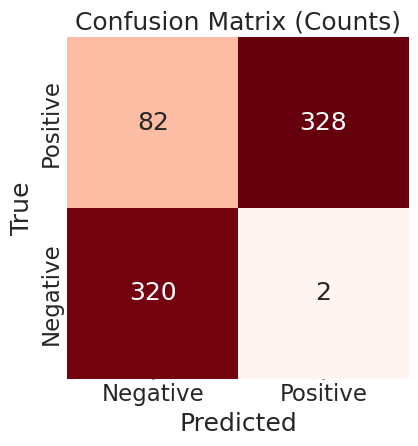

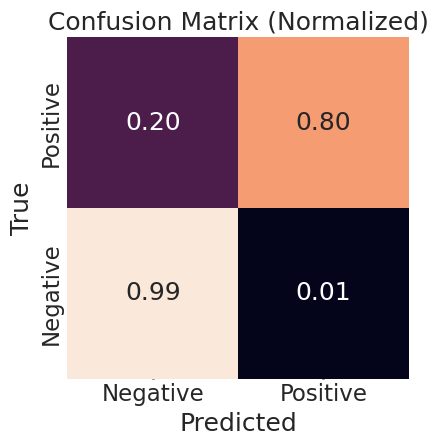

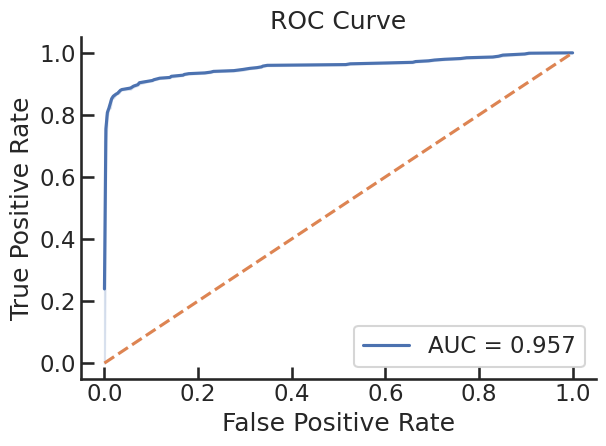

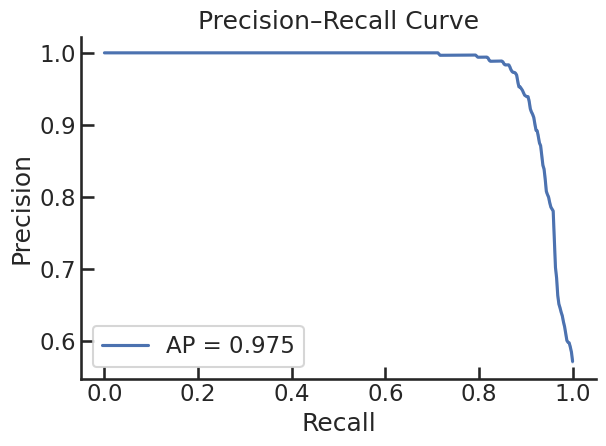

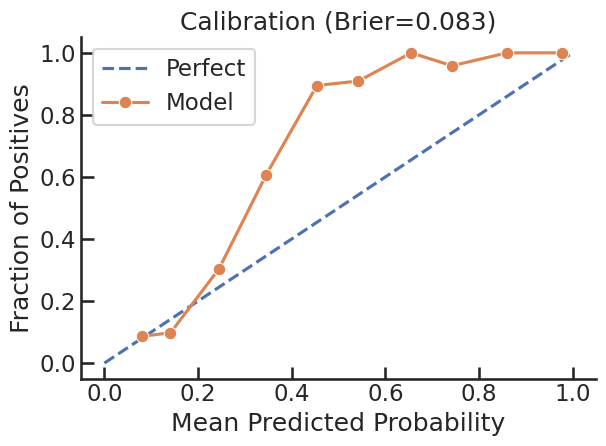

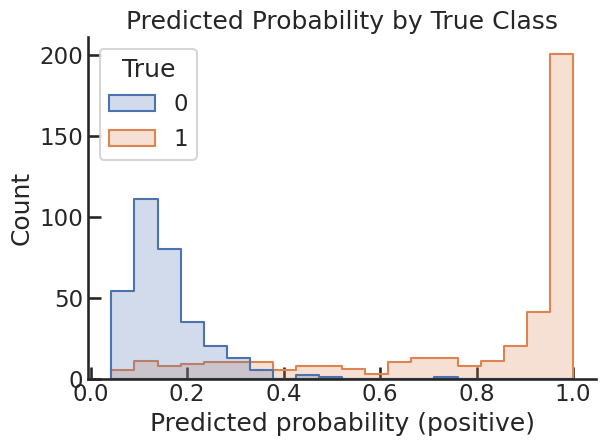

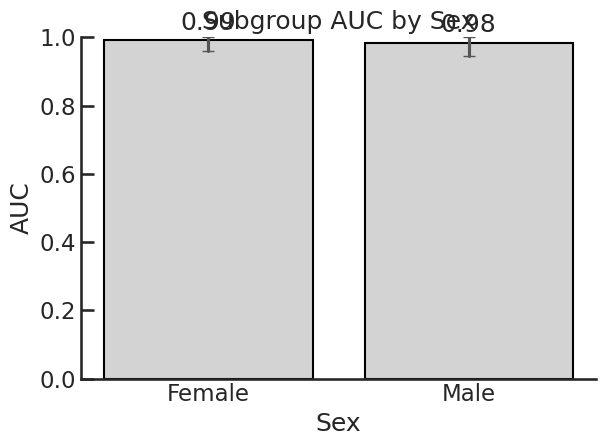

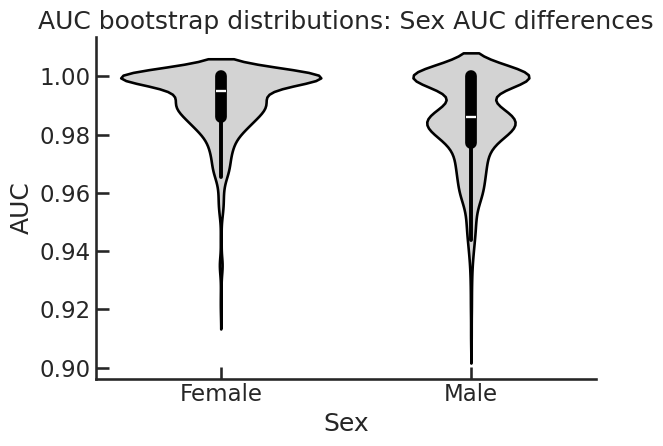

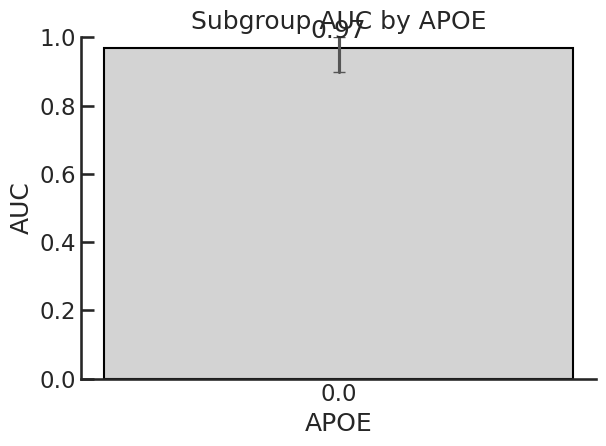

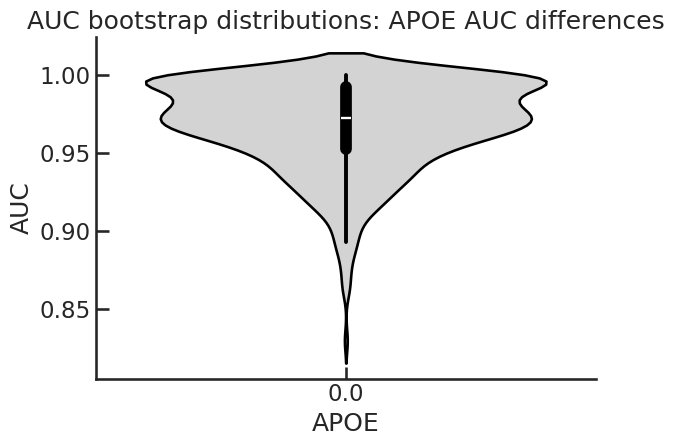

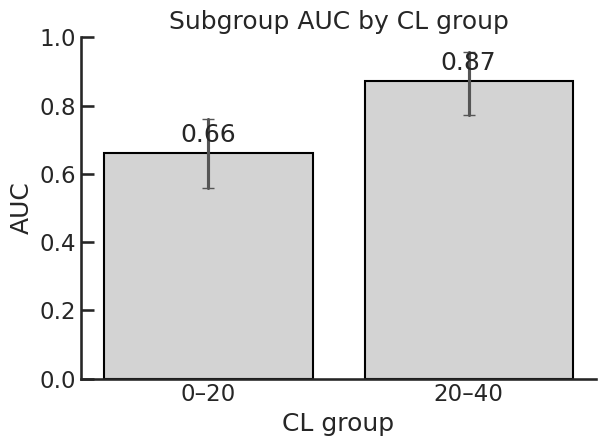

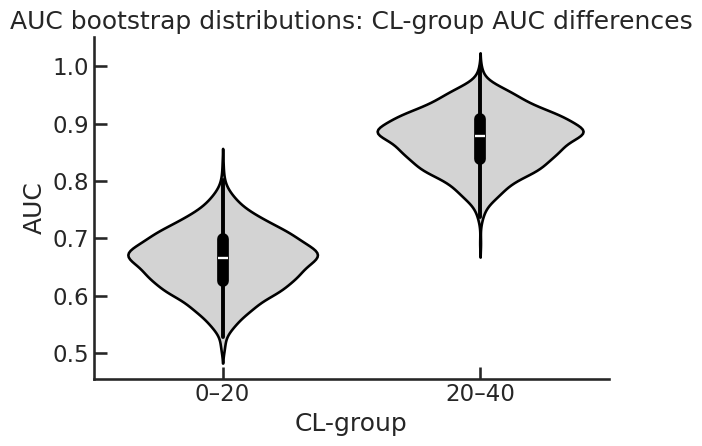

In [72]:
df_result = combine_plot_adni(result_folder, dataset, data_list[0], COLS)

### CL

In [ ]:
import pandas as pd
from src.train import compute_metrics

result_folder = '/proj/berzelius-2024-156/users/x_yxiao/AI-PET/results/CNN3D_CL_2split80-20_stratify-visual_read,site_IDEAS_Inten_Norm_20251004_022211/'
dataset = 'ADNI'
data_list = ['SCANS', 'wsuvr_cere_gaain.nii', 'wsuvr_cere.nii']

for d in data_list:
    print(f'\n---- {dataset}: {d} ----')
    df = pd.read_csv(f'{result_folder}/validation/External_validation_{dataset}_{d}_visual_read.csv')
    metrics = compute_metrics(ycls=df['y'].values.reshape(-1,1), preds=df['pred'].values.reshape(-1,1), probs=df['prob'].values.reshape(-1,1), any_cls=True, yreg=None, cents=None, any_reg=None)
    print(metrics)

,y,pred,ID,site,tracer,CL,visual_read,visual_read_confidence,age,gender,ethnicity,education,diagnosis,AD_pathology,APOE
0,35.0,33.143456,3,17601,1.0,35.0,0.0,3.0,73,2,1,3,13.0,8.0,0
1,14.4,9.103949,7,20004,1.0,14.4,1.0,3.0,74,1,1,6,23.0,4.0,0
2,75.8,75.617530,15,20354,2.0,75.8,0.0,3.0,68,1,4,7,11.0,7.0,0
3,92.6,91.491010,24,20423,2.0,92.6,0.0,3.0,83,1,1,8,11.0,7.0,0
4,1.8,8.993239,35,17601,2.0,1.8,1.0,2.0,74,2,1,8,11.0,6.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2064,93.0,91.531850,10329,21172,2.0,93.0,0.0,3.0,68,2,1,4,11.0,7.0,0
2065,-17.0,-16.687895,10330,17515,1.0,-17.0,1.0,2.0,72,2,1,4,13.0,3.0,0
2066,27.4,23.043228,10332,17601,2.0,27.4,0.0,3.0,81,1,1,5,14.0,7.0,0
2067,113.2,99.337520,10333,17601,2.0,113.2,0.0,3.0,73,1,1,5,11.0,4.0,0


Regression metrics: {'R2': 0.9878677655590256, 'RMSE': 5.4702865800538065, 'MAE': 3.709580052504591, 'MAPE_%': nan, 'Pearson_r': 0.9946618323026714, 'Pearson_p': 0.0, 'Spearman_r': 0.9955173962776924, 'Spearman_p': 0.0}
Hue levels: gender Index([1, 2], dtype='int64')

Summary stats for gender:
   gender     n  mean_resid  mean_CI_low  mean_CI_high  median_resid  \
0       1  1048      -1.037       -1.362        -0.731        -0.953   
1       2  1021      -1.273       -1.593        -0.939        -1.198   

   median_CI_low  median_CI_high  
0         -1.270          -0.641  
1         -1.489          -0.918  

Kruskal–Wallis across gender groups: H=2.167, p=1.4097e-01 (k=2)
  gender: 1 vs 2 | U=555005.000, p=1.4098e-01, Bonferroni p=1.4098e-01
      Cliff's δ = 0.037 (boot mean 0.037, 95% CI [-0.013, 0.088])
      Δ mean residual = 0.230 (95% CI [-0.210, 0.672])
Hue levels: visual_read Index([0.0, 1.0], dtype='float64')

Summary stats for visual_read:
   visual_read     n  mean_resid  

/tmp/ipykernel_3068245/1513820818.py:236: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for g, sub in tmp.groupby(group_col):


  CL_group    n  mean_resid  mean_CI_low  mean_CI_high  median_resid  \
0     0–20  806       0.594        0.292         0.915         0.362   
1    20–40  200      -0.817       -1.302        -0.336        -1.073   
2    40–60  221      -1.631       -2.081        -1.224        -1.808   
3      >60  842      -2.780       -3.189        -2.381        -2.222   

   median_CI_low  median_CI_high  
0         -0.008           0.748  
1         -1.449          -0.532  
2         -2.308          -1.345  
3         -2.533          -1.950  

Kruskal–Wallis across CL_group groups: H=177.984, p=2.4032e-38 (k=4)


/tmp/ipykernel_3068245/1513820818.py:258: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for g, sub in tmp.groupby(group_col):


  CL_group: 0–20 vs 20–40 | U=96273.000, p=2.0333e-05, Bonferroni p=1.2200e-04
      Cliff's δ = 0.194 (boot mean 0.194, 95% CI [0.115, 0.274])
      Δ mean residual = 1.392 (95% CI [0.850, 1.945])
  CL_group: 0–20 vs 40–60 | U=116761.000, p=1.3372e-12, Bonferroni p=8.0233e-12
      Cliff's δ = 0.311 (boot mean 0.310, 95% CI [0.235, 0.383])
      Δ mean residual = 2.208 (95% CI [1.680, 2.753])
  CL_group: 0–20 vs >60 | U=462522.000, p=2.8464e-37, Bonferroni p=1.7079e-36
      Cliff's δ = 0.363 (boot mean 0.364, 95% CI [0.312, 0.412])
      Δ mean residual = 3.372 (95% CI [2.838, 3.919])
  CL_group: 20–40 vs 40–60 | U=25088.000, p=1.6564e-02, Bonferroni p=9.9384e-02
      Cliff's δ = 0.135 (boot mean 0.135, 95% CI [0.018, 0.243])
      Δ mean residual = 0.808 (95% CI [0.139, 1.453])
  CL_group: 20–40 vs >60 | U=102139.000, p=2.7479e-06, Bonferroni p=1.6487e-05
      Cliff's δ = 0.213 (boot mean 0.211, 95% CI [0.130, 0.293])
      Δ mean residual = 1.965 (95% CI [1.337, 2.604])
  CL_grou

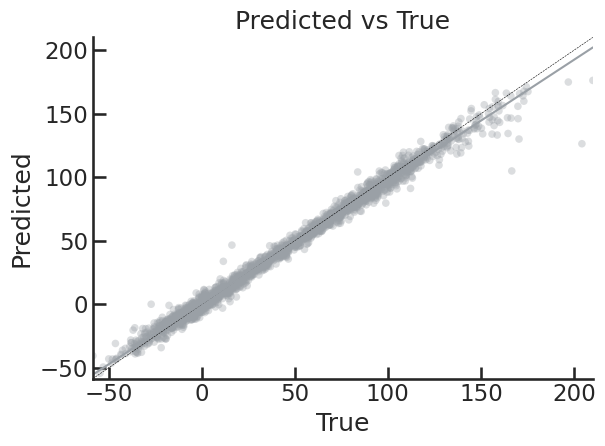

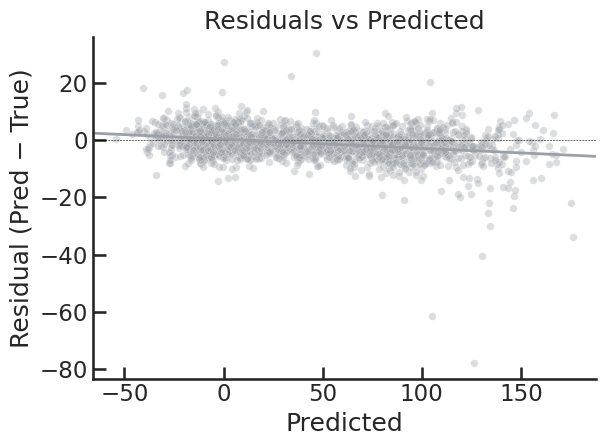

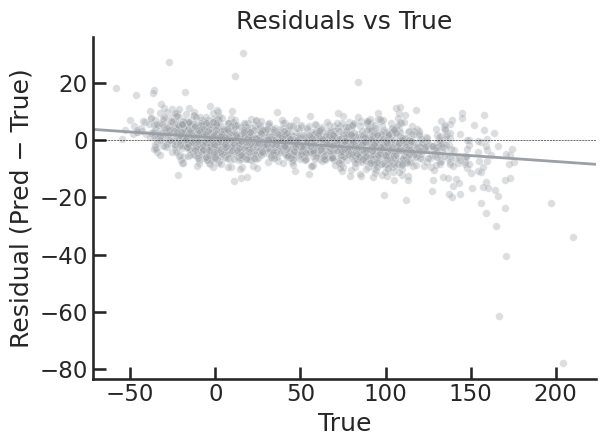

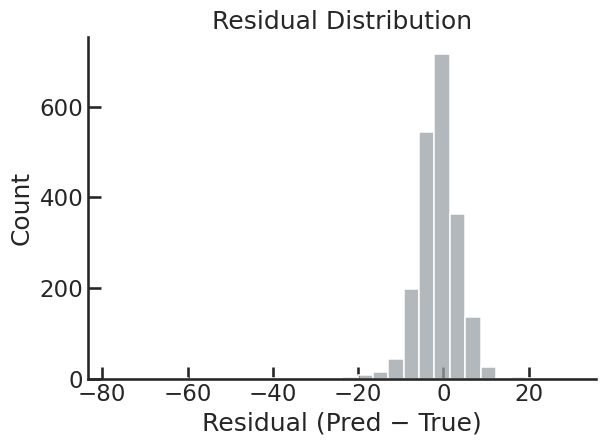

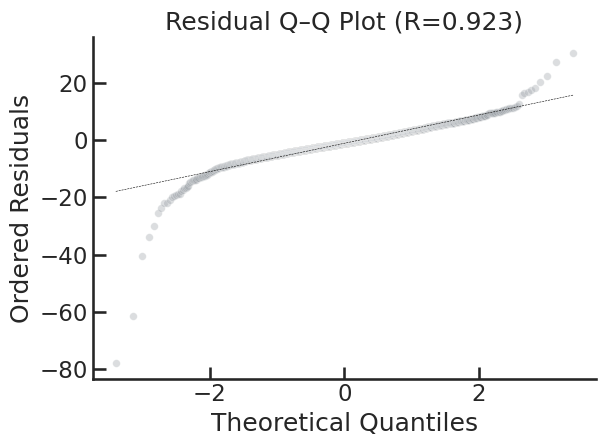

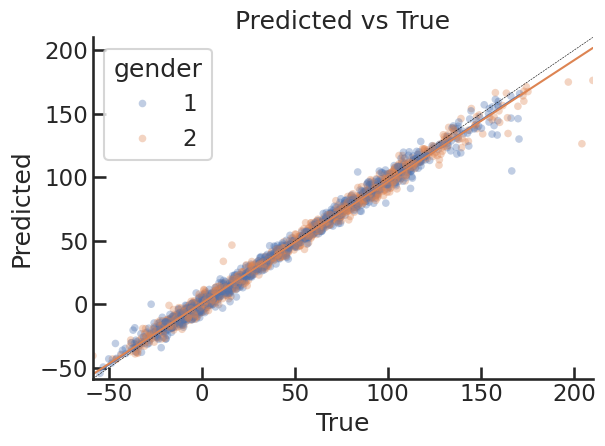

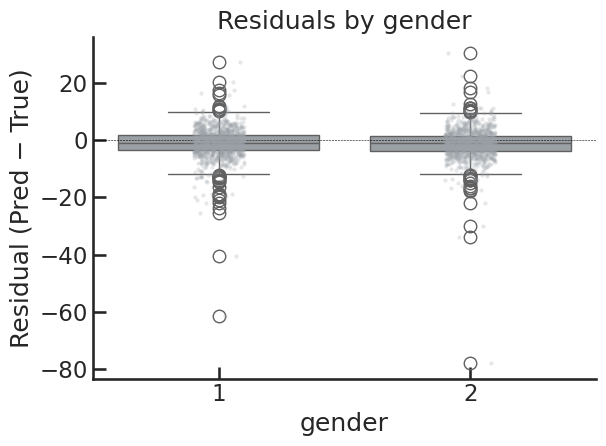

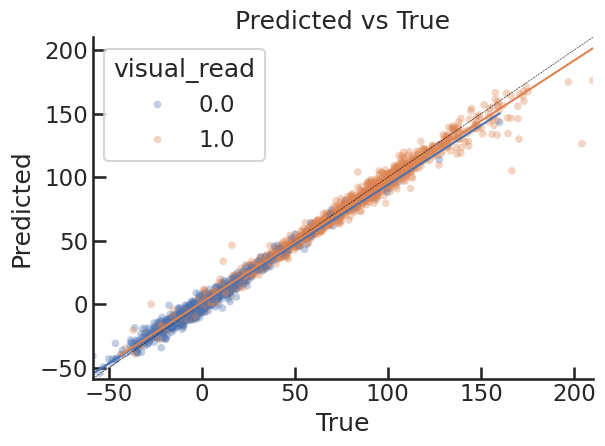

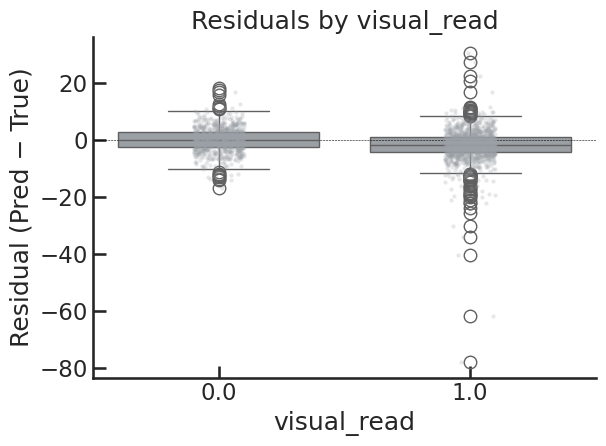

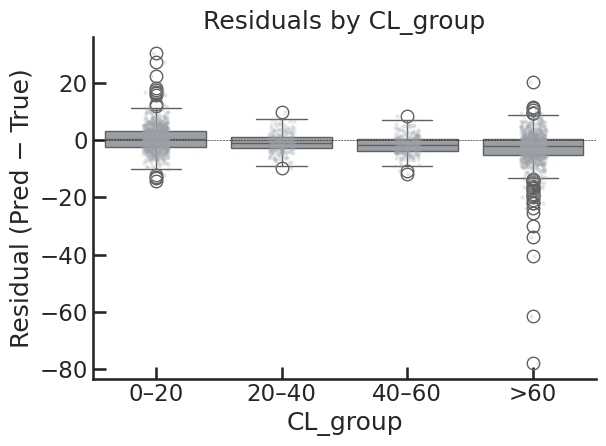

In [ ]:
# Map your dataframe columns here
REG_COLS: Dict[str, str] = dict(y_true="y", y_pred="pred",
                                CL="CL", sex="gender", apoe="APOE", diagnosis="diagnosis", visual_read="visual_read")

plot_regression(df, cols=REG_COLS, save_prefix=result_prefix, add_group_plots=True, n_boot=2000, seed=42)
plt.show()